Glen Langston's Astropy test of the FITS cube tutorial


First run python commands with already install code

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60
import radio_beam


In [13]:
##!pip3 install spectral-cube


Upload the Bonn HI4PI cube with 1.5degree resolution

In [14]:
##!wget ftp://ftp.mpifr-bonn.mpg.de/outgoing/bwinkel/hi4pi_1.5deg.fits
    

In [15]:
###!pip3 install reproject

Now run the remaining tutorial 

In [16]:
# sometimes a package must be installed
# The %%bash syntax allows this
#
!!pip install spectral_cube

from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

Only Download the data once


In [17]:
# Downloads the HI data in a fits file format
#hi_datafile = download_file(
 #   'http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits',
 #   cache=True, show_progress=True)

In [18]:
allsky = "hi4pi_1.5deg.fits"
hi_data = fits.open(allsky)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCubecube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
allsky = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

In [19]:
print(cube)

SpectralCube with shape=(343, 363, 723) and unit=K:
 n_x:    723  type_x: GLON-CAR  unit_x: deg    range:          nan deg:         nan deg
 n_y:    363  type_y: GLAT-CAR  unit_y: deg    range:          nan deg:         nan deg
 n_s:    343  type_s: VRAD      unit_s: m / s  range:  -220183.802 m / s:  220385.717 m / s


Now take a look at one velocity channel of the cube

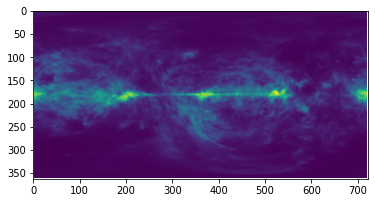

In [20]:
cube[170, :, :].quicklook()  # Slice the cube along the spectral axis, and display a quick image

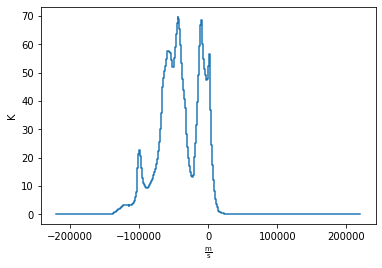

In [21]:
cube[:, 181, 110].quicklook()  # Extract a single spectrum through the data cube

In [11]:
_, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube

In [45]:
hornbeam = 3600.*10.*u.arcsec
beam = radio_beam.Beam(major=hornbeam, minor=hornbeam, pa=0*u.deg)
new_cube = cube.convolve_to(beam)

In [46]:
sub_cube = new_cube[:,  3:360, 20:700]
print(sub_cube)
wcs=WCS(sub_cube.header)
print(wcs)

SpectralCube with shape=(343, 357, 680) and unit=K:
 n_x:    680  type_x: GLON-CAR  unit_x: deg    range:   170.500000 deg:  191.000000 deg
 n_y:    357  type_y: GLAT-CAR  unit_y: deg    range:   -89.000000 deg:   89.000000 deg
 n_s:    343  type_s: VRAD      unit_s: m / s  range:  -220183.802 m / s:  220385.717 m / s
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-CAR'  'GLAT-CAR'  'VRAD'  
CRVAL : 0.0  0.0  0.0  
CRPIX : 342.0  179.0  171.9216300032  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.5  0.5  1288.2149691242  
NAXIS : 680  357  343


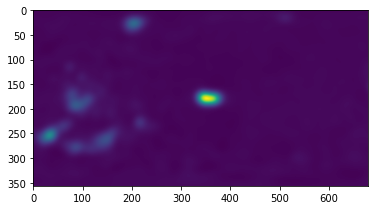

In [47]:
sub_cube[ 40 , :, :].quicklook() 

In [48]:
moment_0 = sub_cube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
moment_1 = sub_cube.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits')
# moment_1.write('hi_moment_1.fits')

print('Moment_0 has units of: ', moment_0.unit)
print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

Moment_0 has units of:  K km / s
Moment_1 has units of:  km / s


In [49]:
print(moment_1.wcs)  # Examine the WCS object associated with the moment map

WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : 0.0  0.0  
CRPIX : 342.0  179.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.5  0.5  
NAXIS : 0  0


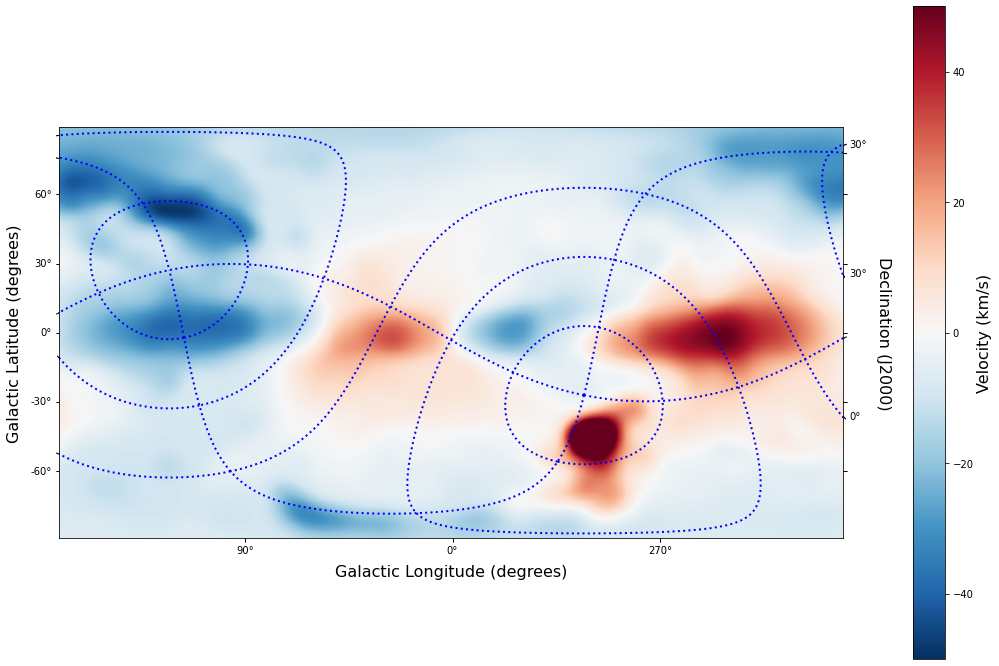

In [52]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=-50, vmax=50)
#ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='blue', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
#levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
#ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

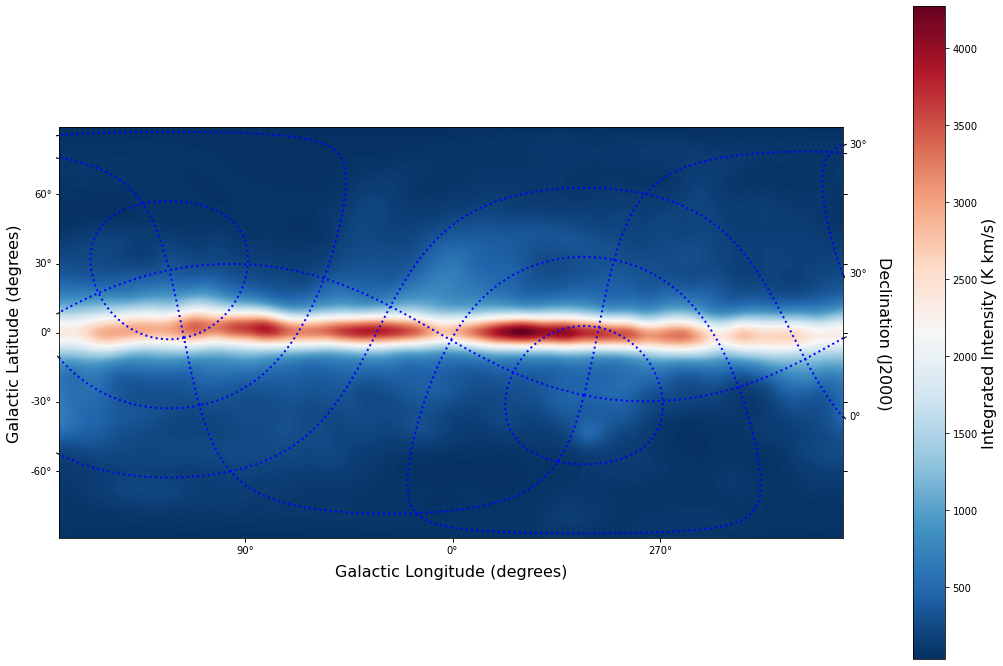

In [55]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_0.wcs)

# Display the moment map image
im = ax.imshow(moment_0.hdu.data, cmap='RdBu_r')
#ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Integrated Intensity (K km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='blue', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
#levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
#ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

In [53]:
sky_0 = allsky.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment
sky_1 = allsky.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment



/home/jail/dlusers/glangsto/.local/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


In [36]:
# Convert Moment_0 to a Column Density assuming optically thin media
sky_hi = sky_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

/data0/sw/anaconda3/lib/python3.8/site-packages/astropy/visualization/wcsaxes/core.py:234: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


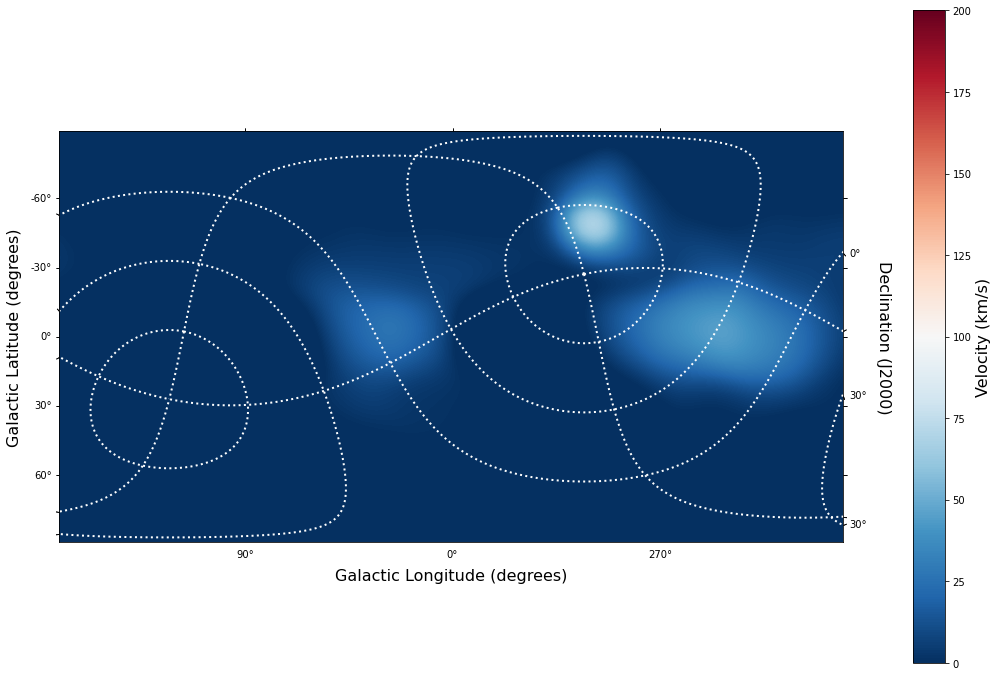

In [37]:
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_0.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=0, vmax=200)
ax.invert_yaxis()  # Flips the Y axis

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(moment_1.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)